# Implementing GPT model from scratch to generate text

In [53]:
from importlib.metadata import version

print(f"matplotlib version: {version('matplotlib')}")
print(f"torch version: {version('torch')}")
print(f"tiktoken version: {version('tiktoken')}")

matplotlib version: 3.10.0
torch version: 2.4.1
tiktoken version: 0.12.0


- GPT-like LLM architecture를 구현하는 것을 목표로 함.
  
![Architecture](./images/llm_cycle.webp)
(image source: LLMs-from-scratch/ch04)

## LLM architecture 구성

- 일반적으로 LLM은 word를 sequential 하게 생성하는 "decoder" 구조를 뜻함.
- 일반적인 DNN 모델들과는 다르게, LLM은 훨씬 더 large.
  - code의 양이 많은 것이 아니라, parameter 수가 많은 것.

![GPT](./images/gpt_decoder.webp)

- 02, 03에서는 작은 embedding dimension을 사용했었음.
- 여기선 GPT-2의 embedding dimension & model size를 사용.
  - 즉, Radford et al. 의 [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 에서 언급된 것 처럼 가장 작은 GPT-2 Model (124 million parameters) 구조를 작성하는 것을 목표로 함.

- 124 million parameter를 가진 GPT-2 model의 configuration은 다음과 같음

In [69]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,        # Vocabulary size
    'context_length': 1024,     # Context(max sequence) length
    'embed_dim': 768,           # Embedding dimension
    'num_heads': 12,            # Number of attention heads
    'num_layers': 12,           # Number of layers(transformer blocks)
    'drop_rate': 0.1,           # Dropout rate
    'qkv_bias': False,          # Q,K,V bias
}

- CONFIG를 하나하나 살펴보면 다음과 같음:
  - `vocab_size`: BPE tokenizer가 지원하는 50257개의 단어로 구성된 vocabulary 크기
  - `context_length`: 모델의 최대 input token 수, 즉 최대 sequence 길이
  - `embed_dim`: embedding size, 각 input token이 `embed_dim=768` 차원의 vector로 변환됨
  - `num_heads`: MHA에서의 head 수
  - `num_layers`: 모델의 transformer block의 개수
  - `drop_rate`: 모델 전체에서 사용하는 dropout rate, overfitting 방지를 위해 training을 하는 동안 hidden unit의 10%를 비활성화
  - `qkv_bias`: MHA에서 Q,K,V를 계산할 때 bias를 포함할 것인지에 대한 여부. modern LLM은 일반적으로 False로 설정하지만, OpenAI에서 제공하는 pretrained GPT-2 weight를 사용할 때 다시 설정

- 생성하는 구조를 다시 살펴보면 다음과 같음:

![GPT_detail](./images/gpt_architecture_detail.webp)

In [55]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['embed_dim'])
        self.position_embedding = nn.Embedding(cfg['context_length'], cfg['embed_dim'])
        self.drop_embedding = nn.Dropout(cfg['drop_rate'])

        # Transformer Block을 여러 개 쌓기 위해 placeholder를 이용
        self.transformer_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['num_layers'])]
        )
        # Layer Normalization을 위환 placeholder
        self.final_norm = DummyLayerNorm(cfg['embed_dim'])
        self.out_head = nn.Linear(cfg['embed_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape

        # token embedding, positional embedding을 더해서 최종 input embedding 구성
        token_embeddings = self.token_embedding(in_idx)
        pos_embeddings = self.position_embedding(
            torch.arange(seq_length, device=in_idx.device)
        ).unsqueeze(0)

        x = token_embeddings + pos_embeddings
        x = self.drop_embedding(x)

        # Transformer block을 통한 forward pass
        x = self.transformer_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)

        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # simple placeholder

    def forward(self, x):
        # 입력을 그대로 return
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        
        # simple placeholder

    def forward(self, x):
        # 입력을 그대로 return
        return x

- 구성하게 되는 GPT-2 model의 구조와 흐름도를 보면 다음과 같음:

![GPT_overall](./images/gpt_overall.webp)

In [86]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)

batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [87]:
torch.manual_seed(62)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 1.5665,  1.1186, -1.5743,  ...,  0.4943, -0.0658, -0.8246],
         [ 1.2288,  2.0925, -0.4349,  ...,  0.2312,  0.1310, -0.7011],
         [-1.6597, -1.5367, -0.7489,  ...,  0.7716,  0.1472, -0.9593],
         [-0.2078,  1.2434, -0.6513,  ...,  0.7067, -0.2921, -0.0421]],

        [[ 1.2642,  0.6182, -1.3649,  ...,  0.1842, -0.0522, -0.8908],
         [ 0.7021,  1.1046, -2.2067,  ...,  0.7645, -0.4357, -0.5698],
         [-1.1339,  0.5524, -0.4693,  ...,  0.6042,  0.1316,  0.8300],
         [-2.0959,  0.4863, -0.0286,  ..., -0.1148,  0.4240,  0.3670]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer normalization

- LayerNorm의 수식은 다음과 같음

    $\mathrm{LayerNorm}(x) = \frac{x - \mu}{\gamma} \cdot \gamma + \beta$

  - 이때, $\gamma$와 $\beta$는 learnable한 scale/shift parameter

- Layer normalization(LayerNorm)은 NN layer의 activation 값을 평균을 0에 가깝게 모으고, 분산을 1로 정규화 함.
  - 이는 training을 안정화 하고, faster convergence를 가능하게 함.
- LayerNorm은 Transformer block 내의 MHA module(추후 구현 예정) 전/후에 모두 적용되고, final output layer 전에도 적용 됨.

![LayerNorm](./images/layernorm.webp)

- LayerNorm이 어떻게 작동하는지 small example을 살펴보자.

In [58]:
torch.manual_seed(62)

# 5-dimension을 가진 2개의 example 생성
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)

print(out)
print("=========="*10)

# 평균과 분산을 계산해보면
    # dim=-1: 마지막 차원(feature dimension)을 따라 계산
    # keepdim=True: 결과 tensor가 입력과 동일한 차원 수를 가지도록 유지
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print(f"Mean: \n {mean}")
print(f"Variance: \n {var}")
print("=========="*10)

# 이제 이 값을 이용해 정규화(normalization)을 수행
out_norm = (out - mean) / torch.sqrt(var)
print(f"Normalized output: \n {out_norm}")

# 정규화 된 mean, variance 확인
mean_norm = out_norm.mean(dim=-1, keepdim=True)
var_norm = out_norm.var(dim=-1, keepdim=True)

print(f"Normalized Mean: \n {mean_norm}")
print(f"Normalized Variance: \n {var_norm}")

tensor([[0.0000, 0.0000, 0.0000, 0.7241, 0.0000, 0.5674],
        [0.0000, 0.5659, 0.0000, 0.0992, 0.0000, 0.3419]],
       grad_fn=<ReluBackward0>)
Mean: 
 tensor([[0.2152],
        [0.1678]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.1137],
        [0.0556]], grad_fn=<VarBackward0>)
Normalized output: 
 tensor([[-0.6385, -0.6385, -0.6385,  1.5093, -0.6385,  1.0447],
        [-0.7118,  1.6882, -0.7118, -0.2912, -0.7118,  0.7383]],
       grad_fn=<DivBackward0>)
Normalized Mean: 
 tensor([[1.9868e-08],
        [5.4638e-08]], grad_fn=<MeanBackward1>)
Normalized Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 이를 따라서 `LayerNorm` class를 만들 수 있다.

In [59]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(embed_dim))    # gamma
        self.shift = nn.Parameter(torch.zeros(embed_dim))   # beta
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        x_norm = (x - mean) / torch.sqrt(var + self.eps)

        out = self.scale * x_norm + self.shift

        return out

**Scale & Shift**

- 일반적인 normalization과 달리, `scale`($\gamma$)과 `shift`($\beta$)가 추가됨.
- 초기 `scale`(multiply by 1)과 `shift`(add 0)은 아무런 효과가 없지만, 이는 learnable parameter.
  - 즉, training을 하는 동안 성능을 향상시킬 수 있다고 판단하는 경우 LLM이 자동으로 조정함.
- 이를 통해 모델은 현재 처리하고 있는 데이터에 가장 적합한 `scale`과 `shift`를 학습할 수 있음.
- 또한 분산의 제곱근을 계산할 때, 더 작은 값(`eps=1e-5`)을 더하는데, 이는 분산이 0일때 division by 0 error를 방지하기 위함임.


**Biased variance**
- 분산 계산 과정에서 `unbiased=False`로 설정하면, $\frac{\sum_{i}{(x_i - \tilde{x})^2}}{n}$ 와 같은 수식으로 계산함.
  - 이때 $n$은 sample size(feature 또는 column의 개수)
  - 이는 분모에 $n-1$을 사용하는 Bessel's correction이 포함되어 있지 않으므로, 분산의 biased estimate를 제공함. (대충 통계학의 자유도 이야기)
- 하지만 LLM에서의 embedding dimension `n`은 일반적으로 very large하므로, `n-1`을 사용하거나 `n`을 사용하거나 큰 차이가 없음(negligible).
- 하지만 GPT-2는 normalization layer에서 biased variance로 학습되었기 때문에, 이후에 load하는 pretrained weight와의 호환성을 위해서도 이 설정을 사용함. (?)
- `LayerNorm`의 동작을 한번 보자.

In [60]:
ln = LayerNorm(embed_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)

print(f"Mean: \n {mean}")
print(f"Variance: \n {var}")

Mean: 
 tensor([[-4.7684e-08],
        [-5.9605e-08]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## Feed-Forward Network with GELU activation

- LLM 안의 Transformer block의 일부로 사용되는 small NN submodule을 구현.
- 일반적인 Deep Learning에서는 activation function으로 ReLU(Rectified Linear Unit)를 사용하는데, 이는 연산이 단순하기도 하고 다양한 NN architecture에서 매우 effective하기 때문.
- LLM에선 전통적인 ReLU 이외에도 다양한 activation function이 사용되는데, 대표적으로 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)가 있음.
- GELU와 SwiGLU는 각각 Gaussian/Sigmoid-gated linear unit을 결합해 더욱 복잡하고 smooth한 activation을 생성함.
  - 형태 자체가 단순한 ReLU와는 다르게 더 나은 성능을 제공함.
- GELU([Hendrycks and Gimpel, 2016](https://arxiv.org/abs/1606.08415))는 여러 방법으로 구현될 수 있음.
  - exact version은 $\mathrm{GELU}(x) = x * \phi(x)$로 정의되며, 여기서 $\phi(x)$는 standard Gaussian distribution의 CDF(cumulative distribution function)를 의미함. 
  
    (즉 표준정규분포의 CDF: $\phi(x) = P(Z \leq x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} \exp\left\{-\frac{u^2}{2}\right\} du$)

- 하지만 일반적으로 computationally cheap한 approximation으로 구현함. <br>
  (GPT-2 역시 마찬가지로 approximation으로 구현됨)

  $\mathrm{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$

In [61]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

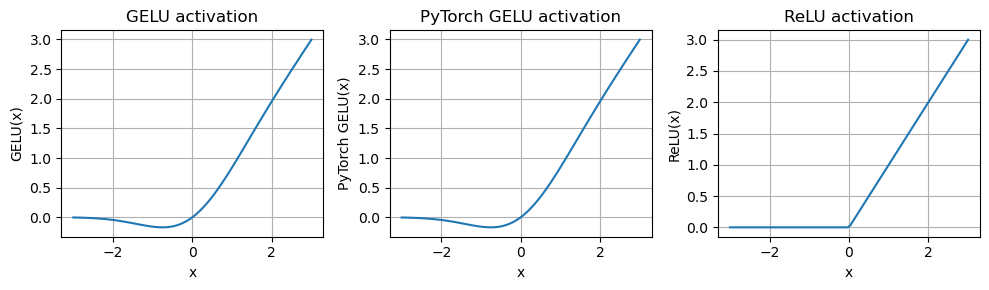

In [62]:
# 시각화를 통한 GELU, ReLU의 형태 확인
import matplotlib.pyplot as plt

# 마찬가지로 최신 PyTorch는 GELU를 제공함(nn.GELU())
gelu, torch_gelu, relu = GELU(), nn.GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_torch_gelu, y_relu = gelu(x), torch_gelu(x), relu(x)
plt.figure(figsize=(10, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_torch_gelu, y_relu], ["GELU", "PyTorch GELU", "ReLU"]), 1):
    plt.subplot(1, 3, i)
    plt.plot(x, y)
    plt.title(f"{label} activation")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 도표를 보면 알 수 있듯, ReLU는 입력값이 양수이면 입력값을 그대로 return하고, 그렇지 않으면 0을 출력하는 piecewise linear function.
- GELU는 ReLU를 approximate하는 non-linear function이고, -0.75 부근을 제외한 음수 값에 대해 0이 아닌 gradient를 제공함.
- 이 activation을 이용해 LLM의 Transformer block에 사용되는 FFN을 구현해보면 다음과 같다:

In [63]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(cfg['embed_dim'], 4 * cfg['embed_dim']),
            GELU(),
            nn.Linear(4 * cfg['embed_dim'], cfg['embed_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

print(FeedForward(GPT_CONFIG_124M))

ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, embed_dim]
x = torch.rand(2, 3, GPT_CONFIG_124M['embed_dim'])
out = ffn(x)
print(f'Output shape of FFN: {out.shape}')

FeedForward(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU()
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)
Output shape of FFN: torch.Size([2, 3, 768])


![FFN_ovrerview](./images/ffn_overview.webp)
![FFN_detail](./images/ffn_detail.webp)

## Add shortcut connection(skip connection or residual connection)

- Computer Vision 분야에서 vanishing gradient를 해결하기 위해 처음 제안된 기법. ([Kaiming He et al., 2015](https://arxiv.org/abs/1512.03385))
  - network를 통해 gradient가 더 잘 흐르도록(flow 하도록) shorter path를 제공.  <br>
    $\rightarrow$ 단순히 하나 이상의 layer를 건너뛰고(skip), 한 layer의 output을 다음 layer의 출력에 더함(add)

  ![Skip_connection](./images/skip_connection.webp)

In [64]:
# Simple example of DNN with skip connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 현재 layer의 output 계산
            layer_output = layer(x)

            # shortcut(skip connection) 적용이 가능한지 확인
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Loss computation
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

# Example usage
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(62)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print('Model without shortcut:')
print_gradients(model_without_shortcut, sample_input)

print("==============================="*10)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print('Model with shortcut:')
print_gradients(model_with_shortcut, sample_input)

Model without shortcut:
layers.0.0.weight has gradient mean of 0.00013949409185443074
layers.1.0.weight has gradient mean of 0.00034243089612573385
layers.2.0.weight has gradient mean of 0.0003053509281016886
layers.3.0.weight has gradient mean of 0.0011113579384982586
layers.4.0.weight has gradient mean of 0.006299514323472977
Model with shortcut:
layers.0.0.weight has gradient mean of 0.002075783908367157
layers.1.0.weight has gradient mean of 0.0051349434070289135
layers.2.0.weight has gradient mean of 0.005600522737950087
layers.3.0.weight has gradient mean of 0.00978672131896019
layers.4.0.weight has gradient mean of 0.06504496186971664


- 위처럼 알 수 있듯, skip connection은 초기 layer에서의 gradient가 소실되는 것을 방지하는데 도움을 줌.

## Connecting attention and linear layers in Transformer block

- 앞서 진행한 내용들을 Transformer block으로 결함.
- Transformer block은 multi-head attention과 FFN layer를 결합한 형태.

In [70]:
# python의 import 문법규칙때문에, .py 명 변경
from _04_previous_modules import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attention = MultiHeadAttention(
            d_in = cfg['embed_dim'],
            d_out = cfg['embed_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['num_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )

        self.ffn = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg['embed_dim'])
        self.norm2 = LayerNorm(cfg['embed_dim'])

        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        """
        input -> LayerNorm -> MHA -> Dropout -> skip connection
        -> LayerNorm -> FFN -> Dropout -> skip connection
        -> output
        """
        # attention with skip connection
        residual = x
        x = self.norm1(x)           # LayerNorm
        x = self.attention(x)       # MHA, [batch, context_length, embed_dim]
        x = self.drop_shortcut(x)   # Dropout
        x = x + residual            # skip(residual) connection

        # FFN with skip connection
        residual = x
        x = self.norm2(x)           # LayerNorm
        x = self.ffn(x)             # FeedForward
        x = self.drop_shortcut(x)   # Dropout
        x = x + residual            # skip(residual) connection

        return x

![Transformer_block](./images/transformer_block.webp)

- 전체적인 구조를 보면 위와 같음.
- input sample이 2개 있고, 각 sample마다 6개의 token을 갖고, 각 token이 768-dimension을 갖는 embedding vector라 가정해보자.
  - Transformer Block은 self-attention을 적용한 후 linear layer를 거쳐 비슷한 크기의 output을 생성함.

In [74]:
torch.manual_seed(62)

# [2, 6, 768] 크기의 sample 생성
x = torch.rand(2, 6, GPT_CONFIG_124M['embed_dim'])  # [batch_size, num_tokens, embed_dim]
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)

print(block)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

TransformerBlock(
  (attention): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_projection): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_shortcut): Dropout(p=0.1, inplace=False)
)
Input shape: torch.Size([2, 6, 768])
Output shape: torch.Size([2, 6, 768])


## Implement GPT model

- 앞서 구현한 구조들에 Transformer block을 연결하면 기초적인 GPT architecture가 완성됨.
- 가장 작은 124M GPT-2의 경우 Transformer block이 12개가 있음.
  - 즉, `cfg['num_layers'] = 12`인 셈.


![GPT_overall_2](./images/gpt_overall_2.webp)

In [77]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['embed_dim'])
        self.position_embedding = nn.Embedding(cfg['context_length'], cfg['embed_dim'])
        self.drop_embedding = nn.Dropout(cfg['drop_rate'])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['num_layers'])]
        )

        self.final_norm = LayerNorm(cfg['embed_dim'])
        self.out_head = nn.Linear(cfg['embed_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape

        # token embedding, positional embedding을 더해서 최종 input embedding 구성
        token_embeddings = self.token_embedding(in_idx)
        pos_embeddings = self.position_embedding(torch.arange(seq_length, device=in_idx.device))
        x = token_embeddings + pos_embeddings   # [batch_size, num_tokens, embed_dim]

        x = self.drop_embedding(x)

        # Transformer block forward pass
        x = self.transformer_blocks(x)

        # last layer norm
        x = self.final_norm(x)

        logits = self.out_head(x)

        return logits

# example
torch.manual_seed(62)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

print("=================="*10)
print(model)
print("=================="*10)
print(f"Input batch: \n {batch}")
print(f"\nOutput shape: {out.shape}")
print("=================="*10)
print(out)


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mult

In [78]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 현재 보면 모델의 파라미터 수가 124M이 아닌 163M.
- original GPT-2 paper를 보면, 가중치 결합(weight tying)을 적용했었음.
  - token embedding layer(`token_emb`)를 output layer로 재사용 했기 때문.
  - 즉, `self.out_head.weight = self.token_emb_weight`로 설정했었음.
- token embedding layer는 **50,257-dimensional one-hot encoded input token을 768-dimension의 embedding으로 투영**하고, output layer는 **768-dimensional embedding을 다시 50,257-dimensional representation으로 변환**해서, 이를 다시 단어(word)로 변경할 수 있도록 함.
- 즉, embedding layer와 output layer는 동일한 수의 weight parameter를 가지고 있음.
  - GPT-2 paper에서 token embedding layer를 output layer로 재사용했었으므로,  <br>
    output layer의 parameter 수를 빼면 아래와 같이 124M이 나오게 됨.

In [79]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [80]:
# 마찬가지로, train에 필요한 메모리 요구량을 계산해보면 다음과 같음
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generating Text

- GPT model은 next token prediction을 아래 그림 예시 처럼 수행하는 모델.

![GPT_imagegen](./images/gpt_imagegen.webp)

- 아래에서 생성하는 `generate_text_simple` function은 text generation에 있어 빠르고 간단한 **greedy decoding**을 수행.
  - 각 step 마다, 모델은 가장 높은 확률을 가진 단어(or token)을 다음 출력으로 선택.  <br>
    (가장 높은 logit 값 == 가장 높은 확률 이므로, softmax를 명시적으로 계산할 필요가 없음.)
- 즉, 다음 그림과 같이 input context가 주어졌을 때, greedy decoding을 통해 next word token을 생성함.

![GPT_imagegen_2](./images/gpt_imagegen_2.webp)


In [82]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx는 현재 context의 index array (batch, n_tokens)
    for _ in range(max_new_tokens):

        # 현재 context가 지원하는 context 크기를 초과하면 이를 slice
        # e.g. LLM이 5개의 token만 지원하고 context 크기가 10인 경우,
        # 마지막 5개의 token만 context로 사용.

        idx_cond = idx[:, -context_size:]

        # Prediction
        with torch.no_grad():
            logits = model(idx_cond)

        # 마지막 time step에만 집중
        # [batch, n_tokens, vocab_size] ==> [batch, vocab_size]
        logits = logits[:, -1, :]

        # softmax를 통해 확률 계산
            # [batch, vocab_size]
        probs = torch.softmax(logits, dim=-1)

        # 확률 값이 가장 높은 vocab의 IDX를 get
            # [batch, 1]
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        # 샘플링 된 index를 sequence에 추가
            # [batch, n_tokens + 1]
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

- `generate_text_simple` 함수의 동작 과정을 보면 다음과 같음:  <br>
  (iterative process를 통해 한번에 1개의 token을 생성)

![GPT_imagegen3](./images/gpt_imagegen_3.webp)

In [85]:
start_context = "O say can you see, by the dawn's early light,"

encoded = tokenizer.encode(start_context)
print(f"encoded: {encoded}")

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f"encoded_tensor.shape: {encoded_tensor.shape}")

print("=================="*10)

# disable dropout
model.eval()

output = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)

print(f"Output: {output}")
print(f"Output length: {len(output[0])}")

print("=================="*10)

decoded_text = tokenizer.decode(output.squeeze(0).tolist())
print(decoded_text)

encoded: [46, 910, 460, 345, 766, 11, 416, 262, 17577, 338, 1903, 1657, 11]
encoded_tensor.shape: torch.Size([1, 13])
Output: tensor([[   46,   910,   460,   345,   766,    11,   416,   262, 17577,   338,
          1903,  1657,    11, 39219, 47190,  3841, 10355, 40386, 29239]])
Output length: 19
O say can you see, by the dawn's early light, EDITION perpendicularfordaltiesJSONChannel


- 현재 model은 train된 상태가 아니므로, random output이 생성되었음.
- Chapter 5에선 model을 train 해볼 것.